# Introduction to `DiscreteHandler`

In [1]:
import os
import yaml
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

from infovar import DiscreteHandler, StandardGetter

## Context

Imaginez que vous recevez une boîte sur laquelle se trouve deux écrans affichant une valeur numérique. La boîte possède également trois curseurs pouvant être tournés pour augmenter ou diminuer une valeur.

Il se trouve que vous n'êtes pas seul à avoir reçu une telle boîte. En effet, 6 de vos collègues ont également reçu une boîte similaire. Un seul détail les différencie toutes : sur leurs boîtes respectives, un ou plusieurs boutons sont cachés. Il est alors impossible de lire la valeur de ces boutons et de les tourner. Les boîtes sont ainsi les suivantes :

- 3 boîtes avec un des trois curseurs caché
- 3 boîtes avec deux des trois curseurs cachés
- votre boîte, avec tous les curseurs visibles

Lorsque vous tournez un des curseurs, et collez votre oreille, vous entendez que les boutons cachées se tournent aussi, a priori aléatoirement. Autre détail important, même dans le cas de la boîte avec tous les boutons, deux configuration similaires ne donnent jamais exactement la même valeur sur les écrans, même si ces dernières sont généralement assez proches.

Ce que vous ne savez pas, c'est que ces boîtes vous ont été envoyé par un statisticien malicieux. Le comportement de ces boîtes est en réalité régit par une simple formule mathématique non-déterministe :

$$ \begin{array}{c}s_1\\s_2\end{array} = \begin{array}{l} (c1-c2)^2 + c3 + \mathcal{N}(0, 0.05)\\\mathrm{e}^{c_3} + \mathcal{N}(0, 0.1)\end{array} $$

In [2]:
def function(
    c1: np.ndarray, c2: np.ndarray, c3: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    ci = cursor n°i (between -1 and 1)
    """
    assert c1.shape == c2.shape == c3.shape
    assert (
        (np.abs(c1) <= 1).all() and (np.abs(c2) <= 1).all() and (np.abs(c3) <= 1).all()
    )

    s1 = (c1 - c2) ** 2 + c3 + np.random.normal(0, 0.05, c1.shape)
    s2 = c1 + np.random.normal(0, 0.1, c1.shape)
    return s1, s2

Votre objectif, ainsi que chacun de vos collègue, est dans la mesure du possible suivant sa boîte, d'essayer de quantifier l'influence des curseurs sur les valeurs affichées par l'écran. Pour cela, vous allez chacun noter les valeurs affichées par l'écran compte tenu des valeurs connues des curseurs. Les valeurs des curseurs seront échantillonnées uniformément entre -1 et 1.

## Getter

TODO

In [3]:
n_samples = 10_000
c1 = np.random.uniform(-1, 1, n_samples)
c2 = np.random.uniform(-1, 1, n_samples)
c3 = np.random.uniform(-1, 1, n_samples)

s1, s2 = function(c1, c2, c3)

getter = StandardGetter(
    ["c1", "c2", "c3"],
    ["s1", "s2"],
    np.column_stack((c1, c2, c3)),
    np.column_stack((s1, s2)),
)

## Discrete handler

Le `DiscreteHandler` est l'outil qui va vous permettre d'analyser statistiquement l'influence des curseurs sur les valeurs affichées sur l'écran.

In [4]:
handler = DiscreteHandler()

handler.set_path("handlers")
handler.set_getter(getter.get)

In [5]:
with open(os.path.join("handlers", "restrictions.yaml"), "r") as f:
    restrictions = yaml.safe_load(f)

handler.set_restrictions(restrictions)

In [ ]:
handler.remove(["s1"])

In [6]:
print("Existing saves:")
for file in handler.get_existing_saves():
    print(file)

Existing saves:
s1.json


In [7]:
inputs_dict = {"restrictions": ["all"], "min_samples": 200, "statistics": ["mi"]}

for s in ["s1", "s2"]:
    for c in ["c1", "c2", "c3"]:
        handler.overwrite(c, s, inputs_dict)

[s2]: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s, x=[c3]]


In [8]:
print("Existing saves:")
for file in handler.get_existing_saves():
    print(file)

Existing saves:
s1.json
s2.json


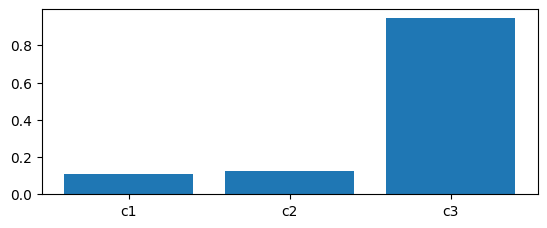

In [15]:
items = handler.read(["c1", "c2", "c3"], "s1", "all", iterable_x=True)
mis = [item["mi"]["value"] for item in items]

plt.figure(figsize=(6.4, 0.5 * 4.8))

plt.bar(np.arange(len(mis)), mis)
plt.xticks(np.arange(len(mis)), ["c1", "c2", "c3"])
plt.title("Mutual information (bits)")

plt.show()

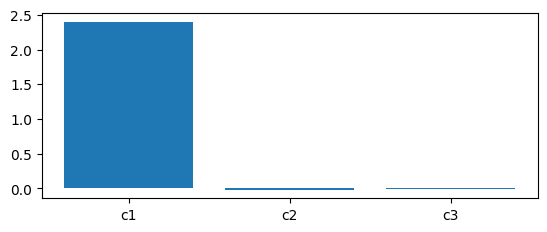

In [16]:
items = handler.read(["c1", "c2", "c3"], "s2", "all", iterable_x=True)
mis = [item["mi"]["value"] for item in items]

plt.figure(figsize=(6.4, 0.5 * 4.8))

plt.bar(np.arange(len(mis)), mis)
plt.xticks(np.arange(len(mis)), ["c1", "c2", "c3"])

plt.show()